In [1]:
# automatic reload 
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import process_funcs as funcs
import json

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px

disable_api_call = True
disable_writing_json = True
save_figs = False

In [2]:
# initialize the Google Maps API
google_maps_api_key = 'INSERT_YOUR_API'
gm = funcs.googleMaps(google_maps_api_key, disable_api_call)


## Clean house price data

In [3]:
# file so big that it is not possible to upload to github

if os.path.exists('data/raw_data_boligsiden.pkl'): 
    # Load the data
    df_raw_data = pd.read_pickle('data/raw_data_boligsiden.pkl')

    #Dropping columns that is unnecessary for analysis
    df_cleaned_data = df_raw_data.drop(columns=['_links',"address","caseID","caseUrl","defaultImage",
                                    "descriptionBody","descriptionTitle","highlighted",
                                    "pageViews","providerCaseID","realEstate",
                                    "realtor","nextOpenHouse","secondaryAddressType",
                                    "images","totalClickCount","totalFavourites","status"])

    #Creating coordinate columns
    df_cleaned_data['coordinates'] = df_cleaned_data['coordinates'].apply(lambda x: tuple(val for key, val in x.items() if key not in ['type']))
    # Splitting in longitude and latitude for easier plotting
    df_cleaned_data['latitude'] = df_cleaned_data['coordinates'].apply(lambda x: x[0])
    df_cleaned_data['longitude'] = df_cleaned_data['coordinates'].apply(lambda x: x[1])
    # Turning to pickle
    df_cleaned_data.to_pickle('cleaned_data_boligsiden.pkl')

    fig = px.scatter_mapbox(df_cleaned_data, lat="latitude",
                            lon="longitude", hover_name="slug",
                            center=dict(lat=55.6979, lon=12.50582),
                            zoom=10, color ='addressType',
                            labels = {'addressType':'Type of housing'})
    fig\
        .update_layout(mapbox_style="open-street-map",
                    margin={"r":0,"t":0,"l":0,"b":0},
                    title = 'Housing data from Boligsiden')\
        .update_traces(marker=dict(size=5))
    fig.show()
else: 
    print('File does not exist')

File does not exist


# Coordinates for busroutes

In [4]:
# load the bus routes dictionary
busroutes_dict = funcs.load_json_file('data/raw/busroutes_dict.json')

for key in list(busroutes_dict.keys()):
    if busroutes_dict[key] == []:
        del busroutes_dict[key]
    else:
        for i in range(len(busroutes_dict[key])):
            busroutes_dict[key][i] = busroutes_dict[key][i]['name']

df = pd.DataFrame.from_dict(busroutes_dict, orient='index', ).T

column_dict = pd.read_pickle('data/raw/busroutes.pkl').set_index('ref')['designation'].to_dict()


df = df.rename(columns=column_dict, )
df = df.stack().reset_index().rename(columns={'level_0':'dont_know','level_1':'bus_line',0:'bus_stop'})

print(f'Number of bus stops: {len(df.bus_stop)}', f'Number of unique bus stops: {len(df.bus_stop.unique())}')

Number of bus stops: 11550 Number of unique bus stops: 6977


# Google Maps Geocoding
## Bus

In [5]:
# remove duplicates to reduce number of API calls
df_stop = df.drop_duplicates(subset=['bus_stop'])

# optional to disable API call
if disable_api_call:
    print('API call disabled')
    outputdict = {}
else: 
    # get the geocode for the bus stops
    list_of_locations = df_stop['bus_stop'].to_list()[:] # define what bus stops to get the geocode for
    outputdict = gm.get_geocode(list_of_locations) # get the geocode


# optional to disable writing to json
if disable_writing_json:
    print('Writing to json disabled')
else: 
    # Write the geocode to the json file
    with open('busstop_geocode.json', 'w') as f:
        json.dump(outputdict, f)

API call disabled
Writing to json disabled


## Metro

In [6]:
# Load in the metro data
df_metro = pd.read_pickle('data/raw/metro.pkl')
df_metro = df_metro.drop_duplicates(subset='MetroStation').reset_index(drop=True, )


# optional to disable API call
if disable_api_call:
    print('API call disabled')
    outputdict = {}
else: 
    # get the geocode for the metro stops
    metrostationsList = df_metro.MetroStation.to_list() # define what metro stops to get the geocode for
    outputdict = gm.get_geocode(metrostationsList[0:0]) # get the geocode


# optional to disable writing to json
if disable_writing_json:
    print('Writing to json disabled')
else: 
    # Write the geocode to the json file
    with open('data/raw/raw_metro_geocode.json', 'w') as f:
        f.write(str(outputdict))

### MANUALLY ADDING THE MISSING METRO STATIONS
# Load the metro geocode
with open('data/raw/raw_metro_geocode.json', 'r') as f:
    metro = eval(f.read())

# Manually add the missing metro stations
manual_dict = {
    'Havneholmen': (55.6603328,12.5619731),
    'Trianglen': (55.6994798,12.5721997),
    'Flintholm': (55.685743,12.4966872),
    'Lindevang': (55.6834738,12.5105452),
    'Forum': (55.6818238,12.5498556),
}
for key in metro.keys():
    if (metro[key] is None) or (metro[key] == []):
        metro[key] = manual_dict[key]
    else:
        metro[key] = tuple(metro[key][0]['geometry']['location'].values())

if disable_writing_json:
    print('Writing to json disabled')
else:
    # Write to json file
    with open('data/raw/metro_geocode.json', 'w') as f:
        f.write(str(metro))

API call disabled
Writing to json disabled
Writing to json disabled


## Calculate distance between stops and houselistings

In [7]:
### Load in coordinates for bus and metro
busstopCordinates = funcs.load_json_file('data/raw/busstop_geocode.json') # Bus data

with open('data/raw/metro_geocode.json', 'r') as f: # Metro data
    metroCoordinates = eval(f.read())

In [8]:
# Turn metro data into a dataframe
df_metro = pd.DataFrame(index=list(metroCoordinates.keys()), data=list(metroCoordinates.values()), columns=['lat','lng'])
df_metro['lat_long'] = df_metro.apply(lambda x: (x['lat'], x['lng']), axis=1)

In [9]:
#### Clean the bus data and turn it into a dataframe

# since we do not have all coordinates, we need to remove the ones we do not have
count = 0
for key in busstopCordinates.keys():
    if (busstopCordinates[key] is None) or (busstopCordinates[key] == []):
        count += 1
print(f'{count} out of {len(busstopCordinates)} is None or [] and {len(busstopCordinates) - count} is not None')

busstopCordinates = {key: busstopCordinates[key] for key in busstopCordinates if ((busstopCordinates[key] is not None) or (busstopCordinates[key] != []))}

busstopCordinatesClean = {}
for key, val in busstopCordinates.items():
    if isinstance(val, list):
        if len(val) > 0:
            busstopCordinatesClean[key] = tuple(val[0]['geometry']['location'].values())


busCorDf = pd.DataFrame.from_dict(busstopCordinatesClean, orient='index').reset_index().rename(columns={'index':'bus_stop',0:'lat',1:'long'}).set_index('bus_stop', )
# collect the two columns into one by making it a tuple
busCorDf['lat_long'] = busCorDf.apply(lambda x: (x['lat'], x['long']), axis=1)

busArray = busCorDf['lat_long'].values

# something wrong with Fyrkatvej (Ring Syd)
busCorDf = busCorDf.loc[busCorDf.index!='Fyrkatvej (Ring Syd)']

# merge coordinates with the bus stops
df = pd.merge(df, busCorDf['lat_long'], left_on='bus_stop', right_index=True, how='left').set_index('bus_stop')

559 out of 6977 is None or [] and 6418 is not None


In [10]:
### Load in the house coordinates
df_house = pd.read_pickle('data/cleaned_data_boligsiden.pkl')
df_house = df_house.drop_duplicates(subset='coordinates').reset_index(drop=True, )

## Ball Tree
### Bus

In [11]:
# Create a ball tree for the bus stops
X = busCorDf['lat_long'].values
ballTree_bus = funcs.ball_tree(coordinates=busCorDf['lat_long'])

# Loop through the house coordinates and find the nearest bus stop
ball_nearest_dict = {}
for i, row in df_house.iterrows():
    coodinate = row['coordinates']
    idx, dist = ballTree_bus.tree_query(coodinate,)
    ball_nearest_dict[coodinate] = {'Nearest':{'index': idx, 'Balltree distance': dist,'coordinate':X[idx]}}
    idxs, dists = ballTree_bus.tree_query_radius(coodinate, radius=0.5)
    ball_nearest_dict[coodinate]['Radius'] = {
        'no_of_stops': len(idxs), 
        'index': [int(id) for id in idxs], 
        'Balltree distance': dists, 
        'coordinate': [tuple(X[i]) for i in idxs],
        'bus_lines': list(df.loc[df['lat_long'].isin([X[i] for i in idxs]), 'bus_line'].unique()),
        }

if disable_writing_json:
    print('Writing to json disabled')
else:    
    # write the nearest_dict to a json file
    with open('data/nearest_dict.json', 'w') as f:
        f.write(str(ball_nearest_dict))

# Example of how to read the json file
with open('data/nearest_dict.json', 'r') as f:
    ball_nearest_dict = eval(f.read())

Writing to json disabled


### Metro

In [12]:
X = df_metro['lat_long'].values
ballTree_metro = funcs.ball_tree(coordinates=df_metro['lat_long'])

nearest_metro_dict = {}
for i, row in df_house.iterrows():
    coodinate = row['coordinates']
    idx, dist = ballTree_metro.tree_query(coodinate,)
    nearest_metro_dict[coodinate] = {'Nearest':{'index': idx, 'Balltree distance': dist,'coordinate':X[idx]}}
    idxs, dists = ballTree_metro.tree_query_radius(coodinate, radius=0.5)
    nearest_metro_dict[coodinate]['Radius'] = {
        'no_of_stops': len(idxs), 
        'index': [int(id) for id in idxs], 
        'Balltree distance': dists, 
        'coordinate': [tuple(X[i]) for i in idxs],
        }

if disable_writing_json:
    print('Writing to json disabled')
else:
    # write the nearest_dict to a json file
    with open('data/nearest_metro_dict.json', 'w') as f:
        f.write(str(nearest_metro_dict))

# Example of how to read the json file
with open('data/nearest_metro_dict.json', 'r') as f:
    nearest_metro_dict = eval(f.read())


Writing to json disabled


## Calculate Distance from house to Rådhuspladsen

In [13]:
# coordinates for the city hall
raedhus_coordinates = (55.6759172,12.5665536)

# set a default non-possible distance to the city hall as default
df_house['Distance_to_centre'] = -1
for i, row in df_house.iterrows():
    df_house.loc[i,'Distance_to_centre'] = funcs.calc_distance(row['coordinates'], raedhus_coordinates)

# turn the coordinates into a dictionary
dist_to_raedhus = df_house.set_index('coordinates', )['Distance_to_centre'].to_dict()

if disable_writing_json:
    print('Writing to json disabled')
else: 
    # write the nearest_dict to a json file
    with open('data/dist_to_raedhus.json', 'w') as f:
        f.write(str(dist_to_raedhus))

with open('data/dist_to_raedhus.json', 'r') as f:
    dist_to_raedhus = eval(f.read())


Writing to json disabled


## Plot example of nearest transit stop

In [14]:
def in_out_circle(ball_tree, coordinates, inner_radius, outer_radius):
    idx_in, dist_in = ball_tree.tree_query_radius(coordinates, radius=inner_radius)
    idx_out, dist_out = ball_tree.tree_query_radius(coordinates, radius=outer_radius)
    # get the coordinates for the inner circle
    in_lat = [i[0] for i in busCorDf['lat_long'].values[idx_in]]
    in_long = [i[1] for i in busCorDf['lat_long'].values[idx_in]]
    # remove the ones that are in the inner circle
    idx_out = [i for i in idx_out if i not in idx_in]
    # get the coordinates for the outer circle
    out_lat = [i[0] for i in busCorDf['lat_long'].values[idx_out]]
    out_long = [i[1] for i in busCorDf['lat_long'].values[idx_out]]
    return in_lat, in_long, out_lat, out_long

# define coodinate for the house
house_coordinate = df_house['coordinates'].values[0]
#
(bus_in_lat, bus_in_long, 
 bus_out_lat, bus_out_long) = in_out_circle(ballTree_bus, house_coordinate, inner_radius=0.5, outer_radius=1)
(metro_in_lat, metro_in_long, 
 metro_out_lat, metro_out_long) = in_out_circle(ballTree_metro, house_coordinate, inner_radius=0.5, outer_radius=1)


/var/folders/yb/hc1k3b754099lzy1_y8dq0xc0000gn/T/ipykernel_13904/122856066.py:19: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = plt.Circle(


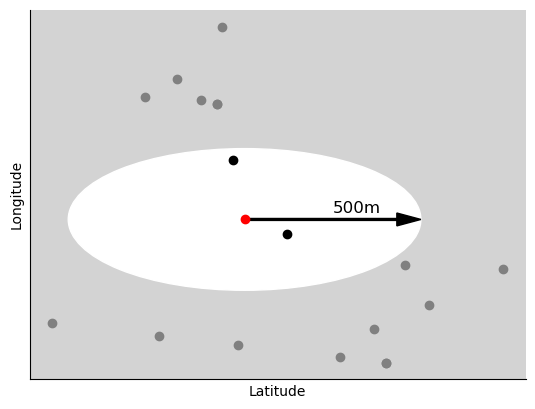

In [15]:
houseCoordinate_lng = house_coordinate[1]
houseCoordinate_lat = house_coordinate[0]

# create a figure and axis
fig, ax = plt.subplots()

# remove the spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# set the labels
ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')

# make everything outside the circle grey
ax.set_facecolor('lightgrey')

# add the circle with the radius of 500m
circle = plt.Circle(
    (houseCoordinate_lat, houseCoordinate_lng), 0.0055, # 500m
    color='white', facecolor='white',fill=True)
ax.add_patch(circle)

# add arrow from center to the edge
ax.arrow(x=houseCoordinate_lat, y=houseCoordinate_lng, 
         dx=0.0055, dy=0,length_includes_head=True, 
         width=0.00015, head_width=0.001, head_length=0.00075, 
            fc='black', ec='black'
         )

# add text below the arrow
ax.text(
    houseCoordinate_lat+0.00275, houseCoordinate_lng+0.0005, 
    '500m', fontsize=12)

# remove labels
ax.tick_params(left = False, right = False , labelleft = False , 
                labelbottom = False, bottom = False) 

# plot stops and house
ax.scatter(bus_in_lat, bus_in_long, c='black')
ax.scatter(bus_out_lat, bus_out_long, c='grey')
ax.scatter(houseCoordinate_lat, houseCoordinate_lng, c='r')

plt.show()
if save_figs:
    fig.savefig('figs/nearest_neighbour.png', dpi=300, bbox_inches='tight')